Install required libraries

In [6]:
!pip install pandas numpy matplotlib statsmodels pmdarima FPDF


  Preparing metadata (setup.py) ... done
  Created wheel for FPDF: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=555d7346032c9827ad4eca3dde7e57845536a0c754fd5c78e8fe0d918a43a58b
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built FPDF


Import Libraries and Load Data

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import os
from fpdf import FPDF

# Load the data
data = pd.read_csv("real_sales_per_day.csv")


Time Series Plot

<ipython-input-9-e5df41cac71f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Y = pd.Series(data.iloc[:276, 1].values, index=pd.date_range(start='1992-01', periods=276, freq='M'))


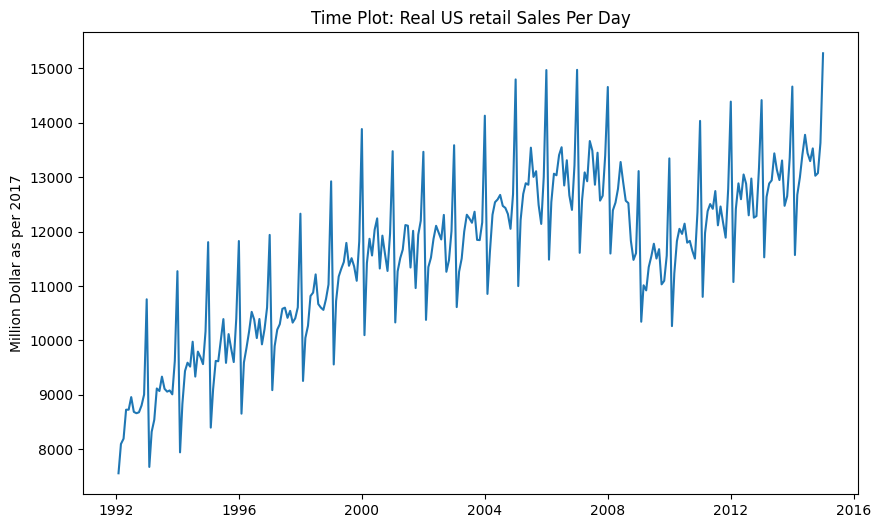

In [9]:
# Declare this as time series data
Y = pd.Series(data.iloc[:276, 1].values, index=pd.date_range(start='1992-01', periods=276, freq='M'))

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(Y)
plt.title("Time Plot: Real US retail Sales Per Day")
plt.ylabel("Million Dollar as per 2017")
plt.savefig('time_plot.png')
plt.show()


Stationarity Tests (ADF and KPSS)

In [10]:
# Perform the ADF test (Dickey-Fuller Test) to check stationarity
def adf_test(series):
    adf_result = adfuller(series)
    p_val = adf_result[1]
    if p_val > 0.05:
        return "Fail to reject null hypothesis: series is non-stationary"
    else:
        return "Reject null hypothesis: series is stationary"

# Perform the KPSS test to check stationarity
def kpss_test(series):
    kpss_stat, p_value, _, _ = kpss(series, regression='c')
    if p_value > 0.05:
        return "Fail to reject null hypothesis: series is stationary"
    else:
        return "Reject null hypothesis: series is non-stationary"

# Running the tests
adf_result = adf_test(Y)
kpss_result = kpss_test(Y)
print(f"ADF Test Result: {adf_result}")
print(f"KPSS Test Result: {kpss_result}")


ADF Test Result: Fail to reject null hypothesis: series is non-stationary
KPSS Test Result: Reject null hypothesis: series is non-stationary


<ipython-input-10-37f3b760c5d2>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, _, _ = kpss(series, regression='c')


Differencing and Trend Removal

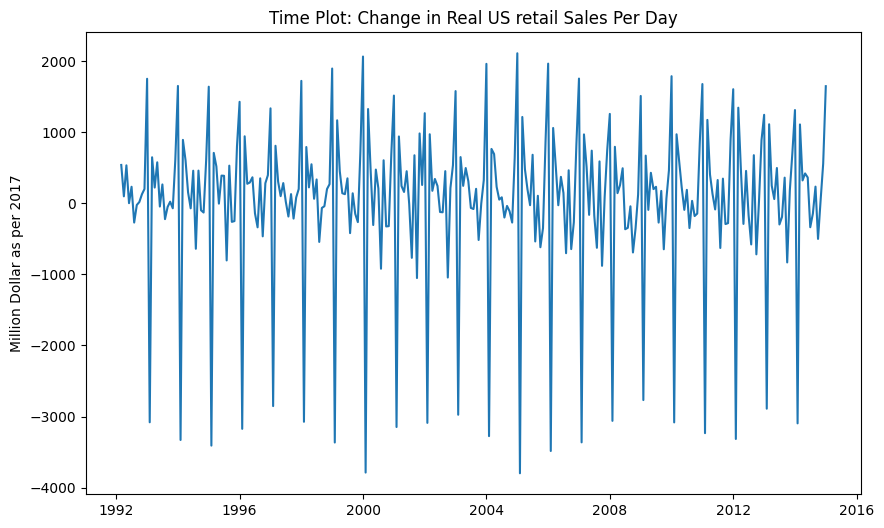

In [12]:
# Differencing to remove trend
DY = Y.diff().dropna()

# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(DY)
plt.title("Time Plot: Change in Real US retail Sales Per Day")
plt.ylabel("Million Dollar as per 2017")
plt.savefig('differenced_plot.png')
plt.show()


Seasonal Decomposition

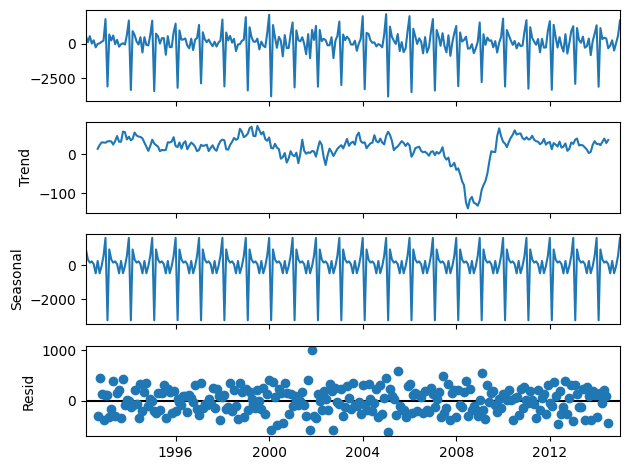

In [13]:
# Seasonal Decompose to check for seasonality
result = seasonal_decompose(DY, model="additive")
result.plot()
plt.savefig('seasonal_decompose.png')
plt.show()


ETS (Exponential Smoothing) Model

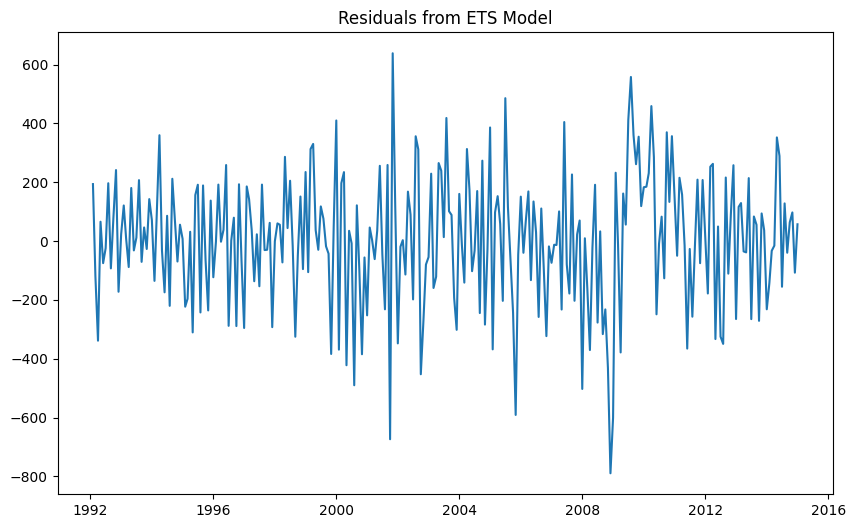

In [14]:
# Fit ETS (Exponential Smoothing) Model
fit_ets = ExponentialSmoothing(Y, seasonal='add', trend='add', seasonal_periods=12).fit()
residuals_ets = fit_ets.resid

# Plot residuals of ETS model
plt.figure(figsize=(10, 6))
plt.plot(residuals_ets)
plt.title('Residuals from ETS Model')
plt.savefig('ets_residuals.png')
plt.show()


ARIMA Model and Forecast

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3735.190, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3714.327, Time=1.56 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=3.73 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3736.405, Time=0.51 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=6.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3714.347, Time=1.95 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=3637.388, Time=4.90 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=3609.738, Time=6.89 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3660.601, Time=1.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3624.991, Time=1.05 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=3.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3656.794, Time=1.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.23 sec
 ARIMA(0,1,1)(2,1,0)[12] 

<ipython-input-15-9b3088f397d8>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=Y.index[-1], periods=37, freq='M')[1:]


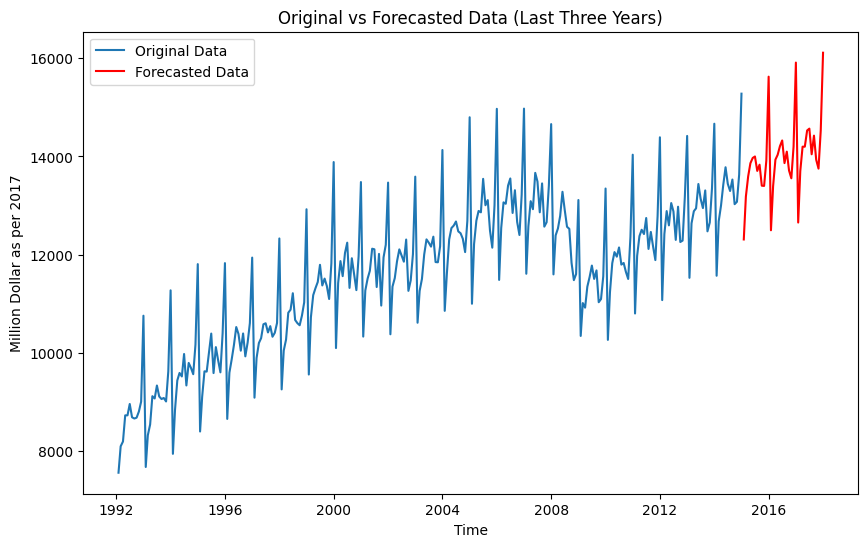

In [15]:
# Fit ARIMA Model
fit_arima = auto_arima(Y, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, stepwise=False)
print(fit_arima.summary())

# Forecast using ARIMA
fcst = fit_arima.predict(n_periods=36)
forecast_index = pd.date_range(start=Y.index[-1], periods=37, freq='M')[1:]

# Plot forecast vs original data
plt.figure(figsize=(10, 6))
plt.plot(Y, label="Original Data")
plt.plot(forecast_index, fcst, label="Forecasted Data", color="red")
plt.title("Original vs Forecasted Data (Last Three Years)")
plt.xlabel("Time")
plt.ylabel("Million Dollar as per 2017")
plt.legend()
plt.savefig('arima_forecast.png')
plt.show()


Generate PDF Report with Results

In [16]:
# Create a PDF file to save results
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Add Title
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, txt="Retail Sales Time Series Forecasting Results", ln=True, align='C')

# ADF and KPSS Test Results
pdf.ln(10)
pdf.cell(200, 10, txt=f"ADF Test Result: {adf_result}", ln=True)
pdf.cell(200, 10, txt=f"KPSS Test Result: {kpss_result}", ln=True)

# Insert the time series plot
pdf.ln(10)
pdf.cell(200, 10, txt="1. Time Series Plot", ln=True)
pdf.image('time_plot.png', x=10, y=None, w=190)

# Insert differenced plot
pdf.ln(10)
pdf.cell(200, 10, txt="2. Differenced Plot", ln=True)
pdf.image('differenced_plot.png', x=10, y=None, w=190)

# Insert Seasonal Decomposition
pdf.ln(10)
pdf.cell(200, 10, txt="3. Seasonal Decomposition", ln=True)
pdf.image('seasonal_decompose.png', x=10, y=None, w=190)

# Insert ETS residuals plot
pdf.ln(10)
pdf.cell(200, 10, txt="4. ETS Residuals", ln=True)
pdf.image('ets_residuals.png', x=10, y=None, w=190)

# Insert ARIMA Forecast plot
pdf.ln(10)
pdf.cell(200, 10, txt="5. ARIMA Forecast", ln=True)
pdf.image('arima_forecast.png', x=10, y=None, w=190)

# Save the PDF file
pdf.output("forecasting_report.pdf")

print("PDF Report Generated!")


PDF Report Generated!
